In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

from skimage.morphology import skeletonize
from scipy.ndimage import distance_transform_edt


ASD_FOLDER = Path(
    "/content/drive/MyDrive/4995DLCV Final Project/Dataset/Children (7-12)/"
    "dataset1 (Handwriting and Drawing Based Early Detection of A)/"
    "Processed_ASD_with_CD (h+d)"
)

OUT_CSV = ASD_FOLDER / "asd_features_augmented.csv"

print("ASD folder:", ASD_FOLDER)
print("Output CSV:", OUT_CSV)


def load_gray(path):
    img = cv2.imread(path, 0)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {path}")
    img = img.astype(np.float32) / 255.0
    return img

def intensity_stats(img):
    vals = img[img < 0.9]  # ignore near-white background
    if len(vals) == 0:
        return 0.0, 0.0
    return float(vals.mean()), float(vals.std())

def local_contrast(img, ksize=7):
    mean = cv2.blur(img, (ksize, ksize))
    contrast = np.abs(img - mean)
    return float(contrast.mean()), float(contrast.std())

def edge_energy(img):
    sobelx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)
    mag = np.sqrt(sobelx**2 + sobely**2)
    return float(mag.mean()), float(mag.std())

def laplacian_var(img):
    lap = cv2.Laplacian(img, cv2.CV_32F)
    return float(lap.var())

def gabor_features(img):
    feats = []
    thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    for theta in thetas:
        kernel = cv2.getGaborKernel((9,9), 2.0, theta, 5.0, 0.5, 0, ktype=cv2.CV_32F)
        f = cv2.filter2D(img, -1, kernel)
        feats.append(float(f.mean()))
        feats.append(float(f.std()))
    return feats  # 8 numbers

def intensity_histogram(img, bins=32):
    hist, _ = np.histogram(img, bins=bins, range=(0,1))
    hist = hist.astype(np.float32)
    hist = hist / (hist.sum() + 1e-8)
    return hist

def soft_binarize(img, thr=0.75):
    return (img < thr).astype(np.uint8)

def curvature_features(skel):
    pts = np.column_stack(np.where(skel > 0))
    if len(pts) < 10:
        return 0.0, 0.0
    diffs = np.diff(pts, axis=0)
    angles = np.arctan2(diffs[:,0], diffs[:,1])
    curvature = np.abs(np.diff(angles))
    return float(curvature.mean()), float(curvature.var())

def stroke_width_features(bw_img):
    dist = distance_transform_edt(bw_img)
    widths = dist[bw_img > 0] * 2
    if len(widths) == 0:
        return 0.0, 0.0
    return float(widths.mean()), float(widths.var())

def orientation_histogram(skel, bins=8):
    pts = np.column_stack(np.where(skel > 0))
    if len(pts) < 10:
        return np.zeros(bins, dtype=np.float32)
    diffs = np.diff(pts, axis=0)
    angles = np.arctan2(diffs[:,0], diffs[:,1])
    hist, _ = np.histogram(angles, bins=bins, range=(-np.pi, np.pi), density=True)
    return hist.astype(np.float32)

def shakiness_feature(skel):
    pts = np.column_stack(np.where(skel > 0))
    if len(pts) < 10:
        return 0.0
    diffs = np.diff(pts, axis=0)
    angles = np.arctan2(diffs[:,0], diffs[:,1])
    high_freq = np.abs(np.diff(angles))
    return float(high_freq.mean())

def jerk_feature(skel):
    pts = np.column_stack(np.where(skel > 0))
    if len(pts) < 10:
        return 0.0
    diffs = np.diff(pts, axis=0)
    angles = np.arctan2(diffs[:,0], diffs[:,1])
    jerk = np.abs(np.diff(np.diff(angles)))
    return float(jerk.mean())

def fractal_dimension(Z):
    # You dropped this later from the augmented CSV,
    # but we can still compute it and then drop the column at the end.
    assert len(Z.shape) == 2
    Z = Z > 0
    sizes = 2 ** np.arange(1, 6)
    counts = []
    for size in sizes:
        S = cv2.resize(Z.astype(np.uint8), (size, size), interpolation=cv2.INTER_NEAREST)
        counts.append(np.sum(S > 0))
    counts = np.array(counts, dtype=np.float32) + 1e-8
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return float(coeffs[0])

def count_segments(bw_img):
    num_labels, _ = cv2.connectedComponents(bw_img.astype(np.uint8))
    return int(num_labels - 1)


def skeleton_topology_features(skel):
    sk = (skel > 0).astype(np.uint8)
    kernel = np.ones((3, 3), dtype=np.uint8)
    neighbor_count = cv2.filter2D(sk, -1, kernel) - sk

    mask = sk > 0
    deg = neighbor_count[mask]

    total_points = int(mask.sum())
    endpoints = int((deg == 1).sum())
    junctions = int((deg >= 3).sum())

    feats = {
        "skel_points": float(total_points),
        "skel_endpoints": float(endpoints),
        "skel_junctions": float(junctions),
        "skel_endpoints_ratio": endpoints / (total_points + 1e-6),
        "skel_junctions_ratio": junctions / (total_points + 1e-6),
    }
    return feats

def orientation_entropy_from_skel(skel, bins=8):
    hist = orientation_histogram(skel, bins=bins)
    if hist.sum() > 0:
        p = hist / (hist.sum() + 1e-8)
    else:
        p = hist + 1e-8
    orient_entropy = -np.sum(p * np.log(p + 1e-8))
    return float(orient_entropy)


def extract_all_features(img_path):
    img = load_gray(img_path)

    inten_mean, inten_std = intensity_stats(img)
    cont_mean, cont_std = local_contrast(img)
    edge_mean, edge_std = edge_energy(img)
    lap_var_val = laplacian_var(img)
    gabor = gabor_features(img)
    hist32 = intensity_histogram(img)

    bw = soft_binarize(img)
    skel = skeletonize(bw > 0).astype(np.uint8)

    curv_mean, curv_var = curvature_features(skel)
    sw_mean, sw_var = stroke_width_features(bw)
    orient = orientation_histogram(skel)
    shake = shakiness_feature(skel)
    jerk_val = jerk_feature(skel)
    frac = fractal_dimension(bw)
    segs = count_segments(bw)

    topo = skeleton_topology_features(skel)
    orient_entropy = orientation_entropy_from_skel(skel)

    features = {
        "inten_mean": inten_mean,
        "inten_std": inten_std,
        "contrast_mean": cont_mean,
        "contrast_std": cont_std,
        "edge_mean": edge_mean,
        "edge_std": edge_std,
        "lap_var": lap_var_val,
        "curvature_mean": curv_mean,
        "curvature_var": curv_var,
        "stroke_width_mean": sw_mean,
        "stroke_width_var": sw_var,
        "shakiness": shake,
        "jerk": jerk_val,
        "fractal_dim": frac,
        "segments": segs,
        # augmented skeleton features:
        "skel_points": topo["skel_points"],
        "skel_endpoints": topo["skel_endpoints"],
        "skel_junctions": topo["skel_junctions"],
        "skel_endpoints_ratio": topo["skel_endpoints_ratio"],
        "skel_junctions_ratio": topo["skel_junctions_ratio"],
        "orient_entropy": orient_entropy,
    }

    # Gabor features
    for i, v in enumerate(gabor):
        features[f"gabor_{i}"] = v

    # Orientation histogram bins
    for i, v in enumerate(orient):
        features[f"orient_bin_{i}"] = float(v)

    # Grayscale histogram bins
    for i, v in enumerate(hist32):
        features[f"hist_bin_{i}"] = float(v)

    # Always store img_path
    features["img_path"] = str(img_path)

    return features


image_exts = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff", ".JPG", ".JPEG", ".PNG")

rows = []
for img_name in tqdm(os.listdir(ASD_FOLDER), desc="Extracting ASD features"):
    if not img_name.lower().endswith(image_exts):
        continue
    img_path = ASD_FOLDER / img_name
    feats = extract_all_features(str(img_path))
    # no age_class here; this is ASD set you want to predict on
    rows.append(feats)

asd_df = pd.DataFrame(rows)
print("Raw ASD features shape (with fractal_dim):", asd_df.shape)

# Drop fractal_dim to match master_features_augmented.csv used by the MLP
if "fractal_dim" in asd_df.columns:
    asd_df = asd_df.drop(columns=["fractal_dim"])
    print("Dropped 'fractal_dim' to match training features.")

print("Final ASD features shape:", asd_df.shape)

# Save to CSV
asd_df.to_csv(OUT_CSV, index=False)
print("Saved ASD features to:", OUT_CSV)


ASD folder: /content/drive/MyDrive/4995DLCV Final Project/Dataset/Children (7-12)/dataset1 (Handwriting and Drawing Based Early Detection of A)/Processed_ASD_with_CD (h+d)
Output CSV: /content/drive/MyDrive/4995DLCV Final Project/Dataset/Children (7-12)/dataset1 (Handwriting and Drawing Based Early Detection of A)/Processed_ASD_with_CD (h+d)/asd_features_augmented.csv


Extracting ASD features: 100%|██████████| 84/84 [07:20<00:00,  5.24s/it]

Raw ASD features shape (with fractal_dim): (83, 70)
Dropped 'fractal_dim' to match training features.
Final ASD features shape: (83, 69)
Saved ASD features to: /content/drive/MyDrive/4995DLCV Final Project/Dataset/Children (7-12)/dataset1 (Handwriting and Drawing Based Early Detection of A)/Processed_ASD_with_CD (h+d)/asd_features_augmented.csv


In [4]:
import pandas as pd
import numpy as np

CSV_PATH = "/content/drive/MyDrive/4995DLCV Final Project/Dataset/Children (7-12)/dataset1 (Handwriting and Drawing Based Early Detection of A)/Processed_ASD_with_CD (h+d)/asd_features_augmented.csv"

df = pd.read_csv(CSV_PATH)
print("Loaded:", df.shape)

print("\nAny NaN values in dataframe?")
print(df.isna().any().any())

# Show which columns contain NaN
nan_cols = df.columns[df.isna().any()].tolist()
print("Columns with NaN:", nan_cols)

# Count NaNs per column
print("\nNaN counts per column:")
print(df.isna().sum())

print("\nAny INF or -INF values?")
mask_inf = np.isinf(df.select_dtypes(include=[np.number])).any()
print(mask_inf.any())

# Which columns contain INF
inf_cols = mask_inf[mask_inf].index.tolist()
print("Columns with INF:", inf_cols)


Loaded: (83, 69)

Any NaN values in dataframe?
False
Columns with NaN: []

NaN counts per column:
inten_mean       0
inten_std        0
contrast_mean    0
contrast_std     0
edge_mean        0
                ..
hist_bin_28      0
hist_bin_29      0
hist_bin_30      0
hist_bin_31      0
img_path         0
Length: 69, dtype: int64

Any INF or -INF values?
False
Columns with INF: []


In [5]:
import os
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

from skimage.morphology import skeletonize
from scipy.ndimage import distance_transform_edt


ASD_FOLDER = Path("/content/drive/MyDrive/4995DLCV Final Project/Dataset/Young Adults (18-40)/HandPD dataset/Age_18-40_Patient_Processed")

OUT_CSV = ASD_FOLDER / "asd_features_augmented.csv"

print("ASD folder:", ASD_FOLDER)
print("Output CSV:", OUT_CSV)


def load_gray(path):
    img = cv2.imread(path, 0)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {path}")
    img = img.astype(np.float32) / 255.0
    return img

def intensity_stats(img):
    vals = img[img < 0.9]  # ignore near-white background
    if len(vals) == 0:
        return 0.0, 0.0
    return float(vals.mean()), float(vals.std())

def local_contrast(img, ksize=7):
    mean = cv2.blur(img, (ksize, ksize))
    contrast = np.abs(img - mean)
    return float(contrast.mean()), float(contrast.std())

def edge_energy(img):
    sobelx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)
    mag = np.sqrt(sobelx**2 + sobely**2)
    return float(mag.mean()), float(mag.std())

def laplacian_var(img):
    lap = cv2.Laplacian(img, cv2.CV_32F)
    return float(lap.var())

def gabor_features(img):
    feats = []
    thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    for theta in thetas:
        kernel = cv2.getGaborKernel((9,9), 2.0, theta, 5.0, 0.5, 0, ktype=cv2.CV_32F)
        f = cv2.filter2D(img, -1, kernel)
        feats.append(float(f.mean()))
        feats.append(float(f.std()))
    return feats  # 8 numbers

def intensity_histogram(img, bins=32):
    hist, _ = np.histogram(img, bins=bins, range=(0,1))
    hist = hist.astype(np.float32)
    hist = hist / (hist.sum() + 1e-8)
    return hist

def soft_binarize(img, thr=0.75):
    return (img < thr).astype(np.uint8)

def curvature_features(skel):
    pts = np.column_stack(np.where(skel > 0))
    if len(pts) < 10:
        return 0.0, 0.0
    diffs = np.diff(pts, axis=0)
    angles = np.arctan2(diffs[:,0], diffs[:,1])
    curvature = np.abs(np.diff(angles))
    return float(curvature.mean()), float(curvature.var())

def stroke_width_features(bw_img):
    dist = distance_transform_edt(bw_img)
    widths = dist[bw_img > 0] * 2
    if len(widths) == 0:
        return 0.0, 0.0
    return float(widths.mean()), float(widths.var())

def orientation_histogram(skel, bins=8):
    pts = np.column_stack(np.where(skel > 0))
    if len(pts) < 10:
        return np.zeros(bins, dtype=np.float32)
    diffs = np.diff(pts, axis=0)
    angles = np.arctan2(diffs[:,0], diffs[:,1])
    hist, _ = np.histogram(angles, bins=bins, range=(-np.pi, np.pi), density=True)
    return hist.astype(np.float32)

def shakiness_feature(skel):
    pts = np.column_stack(np.where(skel > 0))
    if len(pts) < 10:
        return 0.0
    diffs = np.diff(pts, axis=0)
    angles = np.arctan2(diffs[:,0], diffs[:,1])
    high_freq = np.abs(np.diff(angles))
    return float(high_freq.mean())

def jerk_feature(skel):
    pts = np.column_stack(np.where(skel > 0))
    if len(pts) < 10:
        return 0.0
    diffs = np.diff(pts, axis=0)
    angles = np.arctan2(diffs[:,0], diffs[:,1])
    jerk = np.abs(np.diff(np.diff(angles)))
    return float(jerk.mean())

def fractal_dimension(Z):
    # You dropped this later from the augmented CSV,
    # but we can still compute it and then drop the column at the end.
    assert len(Z.shape) == 2
    Z = Z > 0
    sizes = 2 ** np.arange(1, 6)
    counts = []
    for size in sizes:
        S = cv2.resize(Z.astype(np.uint8), (size, size), interpolation=cv2.INTER_NEAREST)
        counts.append(np.sum(S > 0))
    counts = np.array(counts, dtype=np.float32) + 1e-8
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return float(coeffs[0])

def count_segments(bw_img):
    num_labels, _ = cv2.connectedComponents(bw_img.astype(np.uint8))
    return int(num_labels - 1)

def skeleton_topology_features(skel):
    sk = (skel > 0).astype(np.uint8)
    kernel = np.ones((3, 3), dtype=np.uint8)
    neighbor_count = cv2.filter2D(sk, -1, kernel) - sk

    mask = sk > 0
    deg = neighbor_count[mask]

    total_points = int(mask.sum())
    endpoints = int((deg == 1).sum())
    junctions = int((deg >= 3).sum())

    feats = {
        "skel_points": float(total_points),
        "skel_endpoints": float(endpoints),
        "skel_junctions": float(junctions),
        "skel_endpoints_ratio": endpoints / (total_points + 1e-6),
        "skel_junctions_ratio": junctions / (total_points + 1e-6),
    }
    return feats

def orientation_entropy_from_skel(skel, bins=8):
    hist = orientation_histogram(skel, bins=bins)
    if hist.sum() > 0:
        p = hist / (hist.sum() + 1e-8)
    else:
        p = hist + 1e-8
    orient_entropy = -np.sum(p * np.log(p + 1e-8))
    return float(orient_entropy)

def extract_all_features(img_path):
    img = load_gray(img_path)

    inten_mean, inten_std = intensity_stats(img)
    cont_mean, cont_std = local_contrast(img)
    edge_mean, edge_std = edge_energy(img)
    lap_var_val = laplacian_var(img)
    gabor = gabor_features(img)
    hist32 = intensity_histogram(img)

    bw = soft_binarize(img)
    skel = skeletonize(bw > 0).astype(np.uint8)

    curv_mean, curv_var = curvature_features(skel)
    sw_mean, sw_var = stroke_width_features(bw)
    orient = orientation_histogram(skel)
    shake = shakiness_feature(skel)
    jerk_val = jerk_feature(skel)
    frac = fractal_dimension(bw)
    segs = count_segments(bw)

    topo = skeleton_topology_features(skel)
    orient_entropy = orientation_entropy_from_skel(skel)

    features = {
        "inten_mean": inten_mean,
        "inten_std": inten_std,
        "contrast_mean": cont_mean,
        "contrast_std": cont_std,
        "edge_mean": edge_mean,
        "edge_std": edge_std,
        "lap_var": lap_var_val,
        "curvature_mean": curv_mean,
        "curvature_var": curv_var,
        "stroke_width_mean": sw_mean,
        "stroke_width_var": sw_var,
        "shakiness": shake,
        "jerk": jerk_val,
        "fractal_dim": frac,
        "segments": segs,
        # augmented skeleton features:
        "skel_points": topo["skel_points"],
        "skel_endpoints": topo["skel_endpoints"],
        "skel_junctions": topo["skel_junctions"],
        "skel_endpoints_ratio": topo["skel_endpoints_ratio"],
        "skel_junctions_ratio": topo["skel_junctions_ratio"],
        "orient_entropy": orient_entropy,
    }

    # Gabor features
    for i, v in enumerate(gabor):
        features[f"gabor_{i}"] = v

    # Orientation histogram bins
    for i, v in enumerate(orient):
        features[f"orient_bin_{i}"] = float(v)

    # Grayscale histogram bins
    for i, v in enumerate(hist32):
        features[f"hist_bin_{i}"] = float(v)

    # Always store img_path
    features["img_path"] = str(img_path)

    return features


image_exts = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff", ".JPG", ".JPEG", ".PNG")

rows = []
for img_name in tqdm(os.listdir(ASD_FOLDER), desc="Extracting ASD features"):
    if not img_name.lower().endswith(image_exts):
        continue
    img_path = ASD_FOLDER / img_name
    feats = extract_all_features(str(img_path))
    # no age_class here; this is ASD set you want to predict on
    rows.append(feats)

asd_df = pd.DataFrame(rows)
print("Raw ASD features shape (with fractal_dim):", asd_df.shape)

# Drop fractal_dim to match master_features_augmented.csv used by the MLP
if "fractal_dim" in asd_df.columns:
    asd_df = asd_df.drop(columns=["fractal_dim"])
    print("Dropped 'fractal_dim' to match training features.")

print("Final ASD features shape:", asd_df.shape)

# Save to CSV
asd_df.to_csv(OUT_CSV, index=False)
print("Saved ASD features to:", OUT_CSV)


ASD folder: /content/drive/MyDrive/4995DLCV Final Project/Dataset/Young Adults (18-40)/HandPD dataset/Age_18-40_Patient_Processed
Output CSV: /content/drive/MyDrive/4995DLCV Final Project/Dataset/Young Adults (18-40)/HandPD dataset/Age_18-40_Patient_Processed/asd_features_augmented.csv


Extracting ASD features: 100%|██████████| 413/413 [01:17<00:00,  5.36it/s]

Raw ASD features shape (with fractal_dim): (412, 70)
Dropped 'fractal_dim' to match training features.
Final ASD features shape: (412, 69)
Saved ASD features to: /content/drive/MyDrive/4995DLCV Final Project/Dataset/Young Adults (18-40)/HandPD dataset/Age_18-40_Patient_Processed/asd_features_augmented.csv


Loaded training master: (3672, 70)
Training classes: ['Adults (40-65)', 'Children (7-12)', 'Pre-school (3-6)', 'Seniors (65+)', 'Teens (13-17)', 'Young Adults (18-40)']
Training features rebuilt. Input dim: 2346
Loaded ASD features: (412, 69)
Device: cpu
Model loaded!

===== Predictions for ASD images =====
/content/drive/MyDrive/4995DLCV Final Project/Dataset/Young Adults (18-40)/HandPD dataset/Age_18-40_Patient_Processed/mea3-P3.jpg → Adults (40-65)
/content/drive/MyDrive/4995DLCV Final Project/Dataset/Young Adults (18-40)/HandPD dataset/Age_18-40_Patient_Processed/0186-4.jpg → Adults (40-65)
/content/drive/MyDrive/4995DLCV Final Project/Dataset/Young Adults (18-40)/HandPD dataset/Age_18-40_Patient_Processed/0261-7.jpg → Seniors (65+)
/content/drive/MyDrive/4995DLCV Final Project/Dataset/Young Adults (18-40)/HandPD dataset/Age_18-40_Patient_Processed/0261-5.jpg → Adults (40-65)
/content/drive/MyDrive/4995DLCV Final Project/Dataset/Young Adults (18-40)/HandPD dataset/Age_18-40_Patient

/tmp/ipython-input-2591419596.py:146: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(numeric_pred_ages, labels=["ASD dataset"])


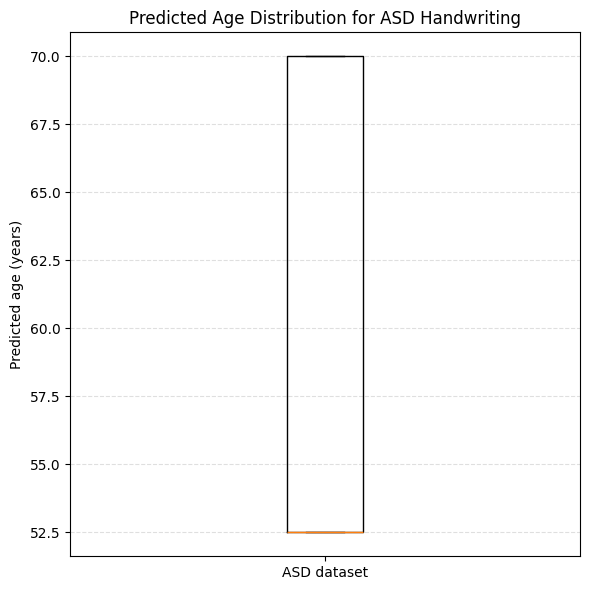

In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import matplotlib.pyplot as plt
from pathlib import Path


MODEL_PATH = "/content/drive/MyDrive/4995DLCV Final Project/best_mlp_poly_features.pt"
MASTER_TRAIN = "/content/drive/MyDrive/DLCV_HW5/Dataset/master_features_augmented.csv"  # <-- training master
ASD_FOLDER = Path("/content/drive/MyDrive/4995DLCV Final Project/Dataset/Young Adults (18-40)/HandPD dataset/Age_18-40_Patient_Processed")

ASD_FEATURES = ASD_FOLDER / "asd_features_augmented.csv"

df_train = pd.read_csv(MASTER_TRAIN)
print("Loaded training master:", df_train.shape)

# Remove fractal_dim if needed
if "fractal_dim" in df_train.columns:
    df_train = df_train.drop(columns=["fractal_dim"])

# Identify features from training
non_feature_cols = ["img_path", "age_class", "split"]
feature_cols_train = [c for c in df_train.columns if c not in non_feature_cols]

feat_train = df_train[feature_cols_train].replace([np.inf, -np.inf], np.nan)
feat_train = feat_train.dropna()

# Labels
y_train = df_train.loc[feat_train.index, "age_class"].values

# Encode labels from training set ONLY
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y_train)
num_classes = len(le.classes_)
print("Training classes:", list(le.classes_))


poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_train_poly = poly.fit_transform(feat_train.values)
input_dim = X_train_poly.shape[1]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)

print("Training features rebuilt. Input dim:", input_dim)


df_asd = pd.read_csv(ASD_FEATURES)
print("Loaded ASD features:", df_asd.shape)

# Remove fractal_dim if exists (to match training)
if "fractal_dim" in df_asd.columns:
    df_asd = df_asd.drop(columns=["fractal_dim"])

# Extract only training feature columns (same column order!)
feat_asd = df_asd[feature_cols_train]

# Poly transform + scale ASD data
X_asd_poly = poly.transform(feat_asd.values)
X_asd_scaled = scaler.transform(X_asd_poly)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

class MLP(nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.net(x)

best_model = MLP(input_dim, num_classes).to(device)
best_model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
best_model.eval()
print("Model loaded!")


X_asd_t = torch.tensor(X_asd_scaled, dtype=torch.float32).to(device)

with torch.no_grad():
    logits = best_model(X_asd_t)
    preds = logits.argmax(dim=1).cpu().numpy()

pred_classes = le.inverse_transform(preds)

df_asd["predicted_age_class"] = pred_classes
df_asd["predicted_label_idx"] = preds


print("\n===== Predictions for ASD images =====")
for img, cls in zip(df_asd["img_path"], df_asd["predicted_age_class"]):
    print(f"{img} → {cls}")


age_midpoints = {
    "Pre-school (3-6)": 4.5,
    "Children (7-12)": 9.5,
    "Teens (13-17)": 15.0,
    "Young Adults (18-40)": 29.0,
    "Adults (40-65)": 52.5,
    "Seniors (65+)": 70.0,
}

numeric_pred_ages = [age_midpoints[c] for c in pred_classes]

plt.figure(figsize=(6, 6))
plt.boxplot(numeric_pred_ages, labels=["ASD dataset"])
plt.ylabel("Predicted age (years)")
plt.title("Predicted Age Distribution for ASD Handwriting")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


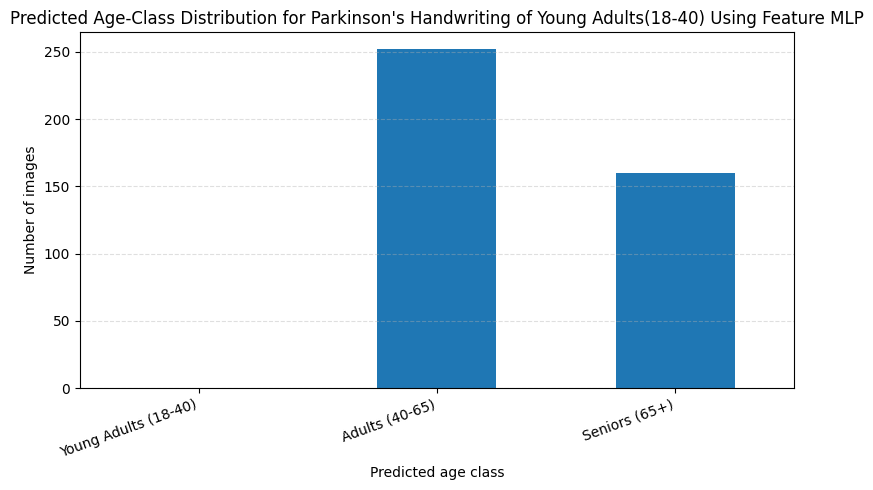

In [14]:
import matplotlib.pyplot as plt

# Assuming df_asd has column 'predicted_age_class'
class_counts = df_asd["predicted_age_class"].value_counts().reindex([
    "Young Adults (18-40)",
    "Adults (40-65)",
    "Seniors (65+)",
])

plt.figure(figsize=(8, 5))
class_counts.plot(kind="bar")
plt.ylabel("Number of images")
plt.xlabel("Predicted age class")
plt.title("Predicted Age-Class Distribution for Parkinson's Handwriting of Young Adults(18-40) Using Feature MLP")
plt.xticks(rotation=20, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()
